<a href="https://colab.research.google.com/github/weedge/doraemon-nb/blob/main/redisxann_usearch_implement_cross_modal_image_text_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run RedisXANN-usearch redis server

In [ ]:
!rm -rf redis && git clone https://github.com/redis/redis && \
  cd redis && \
  git checkout 7.0 && \
  make REDIS_CFLAGS='-Werror' BUILD_TLS=yes && make install && \
  which redis-server && redis-server --version

In [ ]:
!git clone https://github.com/weedge/RedisXANN.git --recursive

In [3]:
!curl https://sh.rustup.rs -sSf > rustup.sh

In [ ]:
!sh rustup.sh -y

In [ ]:
!cd RedisXANN && source "$HOME/.cargo/env" && \
  cargo clean && \
  cargo build --lib --manifest-path rust/usearch/Cargo.toml --release

In [6]:
!redis-server --daemonize yes \
  --loadmodule RedisXANN/target/release/libredisxann_usearch.so is_remove_serialized_file 1 \
  --port 6666 \
  --dbfilename dump.6666.rdb

## Data

1. Oxford-IIIT 宠物数据集 https://www.robots.ox.ac.uk/~vgg/data/pets/

 images.tar.gz（数据集）和 annotations.tar.gz（groundtruth 数据）

In [ ]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz -O images.tar.gz \
  && rm -rf images && tar -zxvf images.tar.gz

In [8]:
!ls images/*jpg | wc -l

7390


In [ ]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz -O annotations.tar.gz \
  && rm -rf annotations && tar -zxvf annotations.tar.gz

## install deps python package
torch、matplotlib、Pillow(colab defualt install)；安装redisx、CLIP(openai clip,阿里巴巴cn_clip)等依赖

In [ ]:
!pip install torch matplotlib Pillow clip cn_clip redisx

In [11]:
!pip list | grep redisx

redisx                           0.1.6


In [12]:
import os
from typing import List

from redis import ResponseError
import torch
from PIL import Image
import pylab
from matplotlib import pyplot as plt
import cn_clip.clip as clip
from cn_clip.clip import available_models


In [13]:
from random import random
from redisx.client import Client
import numpy as np



# change the following configuration for your redis.
REDIS_HOST = "localhost"
REDIS_PORT = 6666
REDIS_DB = 0
REDIS_USERNAME = ""
REDIS_PASSWORD = ""


def get_client() -> Client:
    return Client(
        host=REDIS_HOST,
        port=REDIS_PORT,
        db=REDIS_DB,
        username=REDIS_USERNAME,
        password=REDIS_PASSWORD,
    )


def get_random_vectors(dim: int, n: int):
    return [[(random()/100)-(random()/100) for _ in range(dim)] for _ in range(n)]


def get_numpy_random_vectors_f16(dim: int, n: int):
    #return np.random.default_rng().standard_normal(10, dtype=np.float32)
    return np.random.uniform(-0.1, 0.1, (n, dim)).astype(np.float16)



In [51]:
from typing import Union

from redis import ResponseError
from redisx.define import UsearchQuantizationType
from redisx.ann_usearch import VectorType

cli = get_client()

def create_index(index_name: str, dim:int):
    try:
        return cli.create_index(
            index_name, dim,
            quantization=UsearchQuantizationType.F16)
    except ResponseError as e:
        print(e)
        return None

def get_index(index_name: str):
    try:
        return cli.get_index(index_name)
    except ResponseError as e:
        print(e)
        return None

def delete_index(index_name: str):
    try:
        return cli.del_index(index_name)
    except ResponseError as e:
        print(e)
        return False

def add_vector(index_name: str, name: str, vector: Union[VectorType, str]):
    try:
        return cli.add_vector(index_name, name, vector)
    except ResponseError as e:
        print(e)
        return None

def get_vector(index_name: str, name: str):
    try:
        return cli.get_vector(index_name, name)
    except ResponseError as e:
        print(e)
        return None

def del_vector(index_name: str, name: str):
    try:
        return cli.del_vector(index_name, name)
    except ResponseError as e:
        print(e)
        return False

def kann_search(index_name: str, k: int, query_vector: Union[VectorType, str]):
    try:
        return cli.kann_search(index_name, k, query_vector)
    except ResponseError as e:
        print(e)
        return False

def build_index():
    """
    创建存储图片、文本向量的Vector索引：(使用usearch库建立索引)
    * 图片Key名称为"index_images"、文本Key名称为"index_texts"。
    * 向量维度为1024。
    * 计算向量距离函数为IP。
    """
    ret = get_index("index_images")
    if ret is None:
        create_index("index_images", 1024)
    ret = get_index("index_texts")
    if ret is None:
        create_index("index_texts", 1024)

def test_search():
    dim = 1024
    print("delete_index res {}".format(delete_index("test_idx0")))
    print("create_index res {}".format(create_index("test_idx0", dim)))
    print("get_index res {}".format(get_index("test_idx0")))
    print("\n======= kann search =====\n")
    for i, vector in enumerate(get_random_vectors(dim, 10)):
        name = "n%i" % i
        print("add_vector {} {} res {}".format(
            name, vector[0:10], add_vector("test_idx0", name, vector)))
        # print("get_vector res {}".format(get_vector("test_idx0", name)))

    print("after add, get_index res {}".format(get_index("test_idx0")))
    k = 10
    for i, query_vector in enumerate(get_random_vectors(dim, 3)):
        print("{}. kann_search k {} query_vector {} res {}".format(
            i, k, query_vector[0:10],
            kann_search("test_idx0", k, query_vector)))

    print("delete_index res {}".format(delete_index("test_idx0")))

def test_search_f16():
    dim = 1024
    print("delete_index res {}".format(delete_index("test_idx0")))
    print("create_index res {}".format(create_index("test_idx0", dim)))
    print("get_index res {}".format(get_index("test_idx0")))
    print("\n======= kann search =====\n")
    for i, vector in enumerate(get_numpy_random_vectors_f16(dim, 10)):
        name = "n%i" % i
        print("add_vector {} {} res {}".format(
            name, vector[0:10], add_vector("test_idx0", name, vector)))
        print("get_vector res {}".format(get_vector("test_idx0", name)))

    print("after add, get_index res {}".format(get_index("test_idx0")))
    k = 10
    for i, query_vector in enumerate(get_numpy_random_vectors_f16(dim, 3)):
        print("{}. kann_search k {} query_vector {} res {}".format(
            i, k, query_vector[0:10],
            kann_search("test_idx0", k, query_vector)))

    print("delete_index res {}".format(delete_index("test_idx0")))

In [15]:
get_numpy_random_vectors_f16(10, 2)

array([[-0.07745 , -0.06143 , -0.003405,  0.01894 , -0.069   ,  0.06046 ,
         0.03717 ,  0.0344  , -0.09094 , -0.0654  ],
       [-0.00941 , -0.02945 ,  0.09076 ,  0.003126,  0.0789  , -0.0658  ,
        -0.0885  ,  0.0879  , -0.06174 , -0.0758  ]], dtype=float16)

In [16]:
test_search()

Index: usearch.test_idx0 does not exist
delete_index res False
create_index res True
get_index res {'name': 'usearch.test_idx0', 'dimensions': 1024, 'metric': 'IP', 'quantization': 'F16', 'connectivity': 10, 'expansion_add': 128, 'expansion_search': 3, 'serialization_file_path': '/content/0.usearch.test_idx0.idx', 'serialized_length': 112, 'index_size': 0, 'index_capacity': 10, 'index_mem_usage': 336}

======= kann search =====

add_vector n0 [-0.003601532049086723, 0.003553512092190902, 0.0005713307253696282, 0.003164856415202681, 0.006716318276857466, -0.00168037539811559, 0.00909283793229797, -0.003143207934519211, -0.0022863271125452807, 0.00709293095901424] res True
add_vector n1 [-0.002259431652319067, -0.008530874075834196, -0.003845265988680087, -0.0034559731629862298, -0.005422973158607517, -0.0063599252651915196, 0.00025647301494314596, -0.0065784734053795785, 0.0007801644506349359, 0.005479720247793266] res True
add_vector n2 [0.005115596658846754, -0.0006736306622027394, -0

In [17]:
test_search_f16()

Index: usearch.test_idx0 does not exist
delete_index res False
create_index res True
get_index res {'name': 'usearch.test_idx0', 'dimensions': 1024, 'metric': 'IP', 'quantization': 'F16', 'connectivity': 10, 'expansion_add': 128, 'expansion_search': 3, 'serialization_file_path': '/content/0.usearch.test_idx0.idx', 'serialized_length': 112, 'index_size': 0, 'index_capacity': 10, 'index_mem_usage': 336}

======= kann search =====

add_vector n0 [ 0.088     -0.0765     0.002728   0.0909     0.098      0.01206
 -0.09094   -0.0002682  0.0412    -0.04727  ] res True
get_vector res {'id': 483580353722712076, 'name': 'usearch.test_idx0.n0', 'data': [b'0.0880126953125', b'-0.07647705078125', b'0.002727508544921875', b'0.09088134765625', b'0.0980224609375', b'0.01206207275390625', b'-0.0909423828125', b'-0.00026798248291015625', b'0.04119873046875', b'-0.047271728515625', b'0.06842041015625', b'-0.057861328125', b'0.0322265625', b'0.09735107421875', b'0.08740234375', b'0.0562744140625', b'0.0972

In [18]:
print(delete_index("index_images"))
print(delete_index("index_texts"))
build_index()


Index: usearch.index_images does not exist
False
Index: usearch.index_texts does not exist
False
Index: usearch.index_images does not exist
Index: usearch.index_texts does not exist


In [19]:
get_index("index_images")

{'name': 'usearch.index_images',
 'dimensions': 1024,
 'metric': 'IP',
 'quantization': 'F16',
 'connectivity': 10,
 'expansion_add': 128,
 'expansion_search': 3,
 'serialization_file_path': '/content/0.usearch.index_images.idx',
 'serialized_length': 112,
 'index_size': 0,
 'index_capacity': 10,
 'index_mem_usage': 336}

In [20]:
get_index("index_texts")

{'name': 'usearch.index_texts',
 'dimensions': 1024,
 'metric': 'IP',
 'quantization': 'F16',
 'connectivity': 10,
 'expansion_add': 128,
 'expansion_search': 3,
 'serialization_file_path': '/content/0.usearch.index_texts.idx',
 'serialized_length': 112,
 'index_size': 0,
 'index_capacity': 10,
 'index_mem_usage': 336}

## load vision model
use ResNet-50

In [22]:
# https://github.com/mlfoundations/open_clip
#model, preprocess = clip.load_from_name("RN50", device="cuda", download_root="./")
model, preprocess = clip.load_from_name("RN50", device="cpu", download_root="./")

Loading vision model config from /usr/local/lib/python3.10/dist-packages/cn_clip/clip/model_configs/RN50.json
Loading text model config from /usr/local/lib/python3.10/dist-packages/cn_clip/clip/model_configs/RBT3-chinese.json
Model info {'embed_dim': 1024, 'image_resolution': 224, 'vision_layers': [3, 4, 6, 3], 'vision_width': 64, 'vision_patch_size': None, 'vocab_size': 21128, 'text_attention_probs_dropout_prob': 0.1, 'text_hidden_act': 'gelu', 'text_hidden_dropout_prob': 0.1, 'text_hidden_size': 768, 'text_initializer_range': 0.02, 'text_intermediate_size': 3072, 'text_max_position_embeddings': 512, 'text_num_attention_heads': 12, 'text_num_hidden_layers': 3, 'text_type_vocab_size': 2}


In [ ]:
model.eval()

In [24]:
img = Image.open("/content/images/boxer_18.jpg")

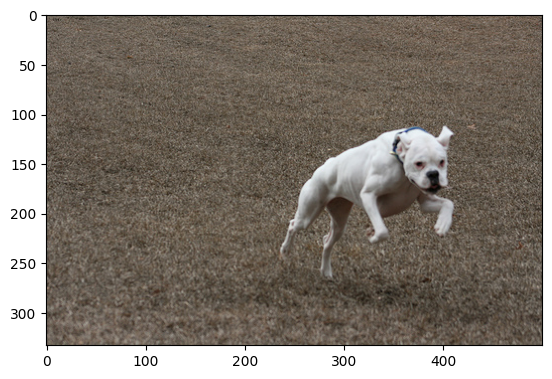

In [25]:
plt.imshow(img)

In [29]:
def insert_images(image_dir):
    """
    需要输入图片的路径，该方法会自动遍历路径下的图片文件。
    同时，该方法会调用extract_image_features方法（通过CLIP模型对图片文件进行预处理，并返回图片的特征信息），
    并行将返回的特征信息存入redisXAnn-usearch中。
    * 向量索引名称为“index_images”（固定）。
    * Key为图片路径及其文件名，例如“/content/images/boxer_18.jpg”。
    * 特征信息为1024维向量。
    """
    file_names = [f for f in os.listdir(image_dir) if (f.endswith('.jpg') or f.endswith('.jpeg'))]
    for file_name in file_names:
        image_feature = extract_image_features(image_dir + "/" + file_name)
        add_vector("index_images", image_dir + "/" + file_name, image_feature)

def extract_image_features(img_name):
    """
    该方法将通过CLIP模型对图片文件进行预处理，并返回图片的特征信息（1024维向量）。
    """
    image_data = Image.open(img_name).convert("RGB")
    infer_data = preprocess(image_data)
    #infer_data = infer_data.unsqueeze(0).to("cuda")
    infer_data = infer_data.unsqueeze(0).to("cpu")
    with torch.no_grad():
        image_features = model.encode_image(infer_data)
        #print("{}\n".format(image_features))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    #print("{}\n".format(image_features))
    return image_features.cpu().numpy()[0]



In [30]:
vector = extract_image_features("/content/images/boxer_18.jpg")
vector,len(vector)
print("{}\n".format(vector))
with open("./vector.txt", "w") as txt_file:
    txt_file.write(','.join(str(item) for item in vector))

[ 0.02054355 -0.00115371  0.01126053 ... -0.00633897 -0.03747317
  0.03198247]



In [31]:
!cat ./vector.txt

0.020543553,-0.001153708,0.011260527,0.02451425,-0.02327513,0.058054704,-0.032867488,0.02617385,0.030176746,0.012453335,-0.02494805,0.012572644,-0.011744662,-0.018142171,-0.0034411468,-0.014761687,0.005665269,-0.01727629,0.02639604,-0.005078728,-0.017069984,-0.006387267,0.054648206,-0.018836284,0.013899771,-0.004697601,-0.0017704788,0.019975407,-0.032312624,0.010688265,-0.009040247,0.027641704,-0.000314891,0.014506286,-0.025536748,0.00028635203,-0.011683876,0.044329796,0.03477197,0.00076420023,0.030429365,-0.018176634,-0.027404966,-0.01240229,0.017327368,-0.009702158,0.029808855,0.0070530423,-0.008286176,-0.010024781,0.007403461,0.016295275,-0.04490293,-0.00760834,0.044512853,-0.02545126,-0.02512305,-0.0059993365,0.018141555,0.0136175575,-0.006728814,0.037532926,0.005817879,-0.015634302,-0.021107862,0.054880776,-0.015157926,0.010906991,-0.021868726,-0.0064342683,-0.02910418,0.041892752,0.007078478,0.035596,-0.009666463,-0.040781338,-0.010214103,0.018525396,0.050657034,-0.014351638,0.01

In [32]:
add_vector("index_images","/content/images/boxer_18.jpg", vector)

True

In [33]:
res = get_vector("index_images","/content/images/boxer_18.jpg")
print(res)

{'id': 483580618668507148, 'name': 'usearch.index_images./content/images/boxer_18.jpg', 'data': [b'0.020538330078125', b'-0.0011539459228515625', b'0.011260986328125', b'0.0245208740234375', b'-0.0232696533203125', b'0.05804443359375', b'-0.032867431640625', b'0.0261688232421875', b'0.030181884765625', b'0.012451171875', b'-0.0249481201171875', b'0.0125732421875', b'-0.01174163818359375', b'-0.0181427001953125', b'-0.00344085693359375', b'-0.01476287841796875', b'0.005664825439453125', b'-0.01727294921875', b'0.026397705078125', b'-0.005077362060546875', b'-0.0170745849609375', b'-0.00638580322265625', b'0.054656982421875', b'-0.018829345703125', b'0.0139007568359375', b'-0.00469970703125', b'-0.00177001953125', b'0.0199737548828125', b'-0.032318115234375', b'0.01068878173828125', b'-0.00904083251953125', b'0.02764892578125', b'-0.00031495094299316406', b'0.01450347900390625', b'-0.025543212890625', b'0.000286102294921875', b'-0.01168060302734375', b'0.044342041015625', b'0.03475952148

In [34]:
print("{}".format(kann_search("index_images",1,vector)))

{'size': 1, 'vals': [{'similarity': '-1.1920928955078125e-07', 'name': 'usearch.index_images./content/images/boxer_18.jpg', 'id': 483580618668507148}]}


In [ ]:
del_vector("index_images","/content/images/boxer_18.jpg")

In [40]:
def insert_text(text):
    """
    需要输入需存储的文本，该方法会调用extract_text_features方法（通过CLIP模型对文本进行预处理，并返回文本的特征信息），
    并行将返回的特征信息存入redisXAnn-usearch中。
    存入Tair的格式为：
    * 向量索引名称为“index_texts”（固定）。
    * Key为文本内容，例如“奔跑的狗”。
    * 特征信息为1024维向量。
    """
    text_features = extract_text_features(text)
    add_vector("index_texts", text, text_features)


def extract_text_features(text):
    """
    该方法将通过CLIP模型对文本进行预处理，并返回文本的特征信息（1024维向量）。
    """
    #text_data = clip.tokenize([text]).to("cuda")
    text_data = clip.tokenize([text]).to("cpu")
    with torch.no_grad():
        text_features = model.encode_text(text_data)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features.cpu().numpy()[0]



In [62]:
def query_images_by_text(q_text, topK):
    """
    该方法将用于以文搜图。
    需要输入待搜索的文本内容（text）和返回的结果数量（topK）。
    该方法会通过CLIP 模型将待查询的文本内容进行预处理，然后通过USEARCH.SEARCH.KANN命令，
    查询redis数据库中与该文本描述最为相似的图片。
    将返回目标图片名称name，id和相似值similarity，
    这里选择默认metric: IP(内积), 相似值similarity为距离，越小，表示相似度越高。
    """
    q_text_feature = extract_text_features(q_text)
    result = kann_search("index_images", topK, q_text_feature)
    print("topK {} q {} result {}",topK,q_text_feature,result)
    if result == None:
      return None
    for item in result["vals"]:
        print("{}".format(item))
        name = str(item["name"]).split(".index_images.")[1]
        img = Image.open(name)
        plt.imshow(img)
        pylab.show()


def query_texts_by_image(image_path, topK=3):
    """
    该方法将用于以图搜文。
    需要输入待查询图片的路径和返回的结果数量（topK）。
    该方法会通过CLIP 模型将待查询的图片内容进行预处理，然后通过Vector的TVS.KNNSEARCH命令，查询Tair数据库中与该图片最为吻合的文本。
    将返回目标文本的Key名称和相似距离（distance），其中相似距离（distance）越小，表示相似度越高。
    """
    image_feature = extract_image_features(image_path)
    result = kann_search("index_texts", topK, image_feature)
    print("topK {} q {} result {}",topK,image_feature,result)
    if result == None:
      return None
    for i,item in enumerate(result["vals"]):
        name = str(item["name"]).split(".index_texts.")[1]
        print("{} => {} {}".format(i,name,item))



In [37]:
# 宠物图片数据集的路径为“./images”，写入图片数据。
insert_images("./images")

In [54]:
get_index("index_images")

{'name': 'usearch.index_images',
 'dimensions': 1024,
 'metric': 'IP',
 'quantization': 'F16',
 'connectivity': 10,
 'expansion_add': 128,
 'expansion_search': 3,
 'serialization_file_path': '/content/0.usearch.index_images.idx',
 'serialized_length': 15846592,
 'index_size': 7390,
 'index_capacity': 14780,
 'index_mem_usage': 37867168}

In [41]:
# 写入文本示例数据（"狗"、"白色的狗"、"奔跑的白色的狗"）。
insert_text("狗")
insert_text("白色的狗")
insert_text("奔跑的白色的狗")


In [42]:
get_index("index_texts")

{'name': 'usearch.index_texts',
 'dimensions': 1024,
 'metric': 'IP',
 'quantization': 'F16',
 'connectivity': 10,
 'expansion_add': 128,
 'expansion_search': 3,
 'serialization_file_path': '/content/0.usearch.index_texts.idx',
 'serialized_length': 6544,
 'index_size': 3,
 'index_capacity': 10,
 'index_mem_usage': 20971792}

topK {} q {} result {} 3 [-0.00501335 -0.01027817  0.02934459 ... -0.0051375   0.03256056
  0.00637217] {'size': 3, 'vals': [{'similarity': '0.41315895318984985', 'name': 'usearch.index_images../images/boxer_18.jpg', 'id': 483581387383767052}, {'similarity': '0.41831374168395996', 'name': 'usearch.index_images../images/miniature_pinscher_87.jpg', 'id': 483581841459118092}, {'similarity': '0.42326277494430542', 'name': 'usearch.index_images../images/german_shorthaired_59.jpg', 'id': 483581691839905804}]}
{'similarity': '0.41315895318984985', 'name': 'usearch.index_images../images/boxer_18.jpg', 'id': 483581387383767052}



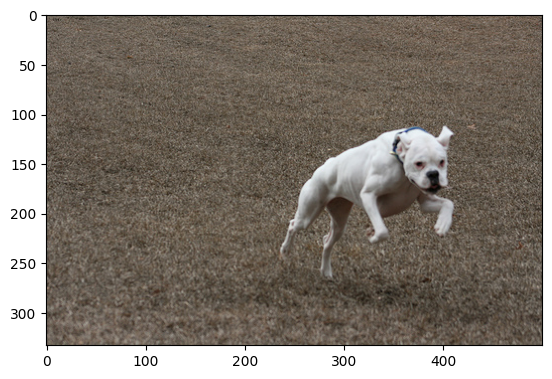

{'similarity': '0.41831374168395996', 'name': 'usearch.index_images../images/miniature_pinscher_87.jpg', 'id': 483581841459118092}



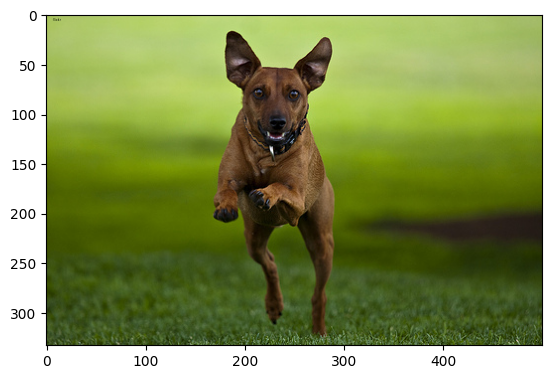

{'similarity': '0.42326277494430542', 'name': 'usearch.index_images../images/german_shorthaired_59.jpg', 'id': 483581691839905804}



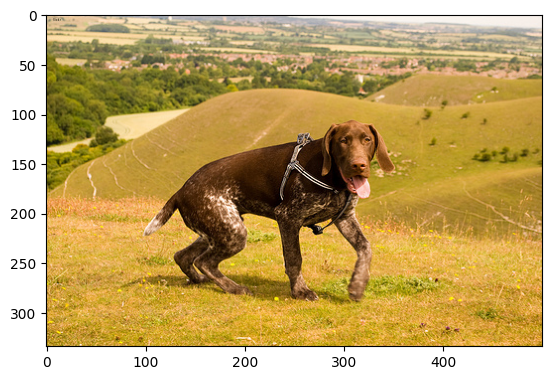

In [59]:
# 以文搜图，查询最符合文本"奔跑的狗"的三张图。
query_images_by_text("奔跑的狗", 3)

In [63]:
# 以图搜文，指定图片路径，查询比较符合图片描述的文本。
query_texts_by_image("./images/boxer_18.jpg",3)


topK {} q {} result {} 3 [ 0.02054355 -0.00115371  0.01126053 ... -0.00633897 -0.03747317
  0.03198247] {'size': 3, 'vals': [{'similarity': '0.40503507852554321', 'name': 'usearch.index_texts.奔跑的白色的狗', 'id': 483583377648123916}, {'similarity': '0.44666534662246704', 'name': 'usearch.index_texts.白色的狗', 'id': 483583377581015052}, {'similarity': '0.45523172616958618', 'name': 'usearch.index_texts.狗', 'id': 483583377513906188}]}
0 => 奔跑的白色的狗 {'similarity': '0.40503507852554321', 'name': 'usearch.index_texts.奔跑的白色的狗', 'id': 483583377648123916}
1 => 白色的狗 {'similarity': '0.44666534662246704', 'name': 'usearch.index_texts.白色的狗', 'id': 483583377581015052}
2 => 狗 {'similarity': '0.45523172616958618', 'name': 'usearch.index_texts.狗', 'id': 483583377513906188}


In [64]:
print(delete_index("index_images"))
print(delete_index("index_texts"))
print(get_index("index_images"))
print(get_index("index_texts"))

1
1
Index: usearch.index_images does not exist
None
Index: usearch.index_texts does not exist
None
